# Active Learning

## Imports

In [1]:
try:
    from astra.torch.models import ResNetClassifier
except:
    %pip install git+https://github.com/sustainability-lab/ASTRA

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchsummary
from tqdm import tqdm

import umap

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import ResNetClassifier

# Netron, ONNX for model visualization
try:
    import netron
except ModuleNotFoundError:
    %pip install netron
    import netron

try:
    import onnx
except ModuleNotFoundError:
    %pip install onnx
    import onnx

import copy


/home/patel_zeel/ASTRA/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/patel_zeel/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset

In [4]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

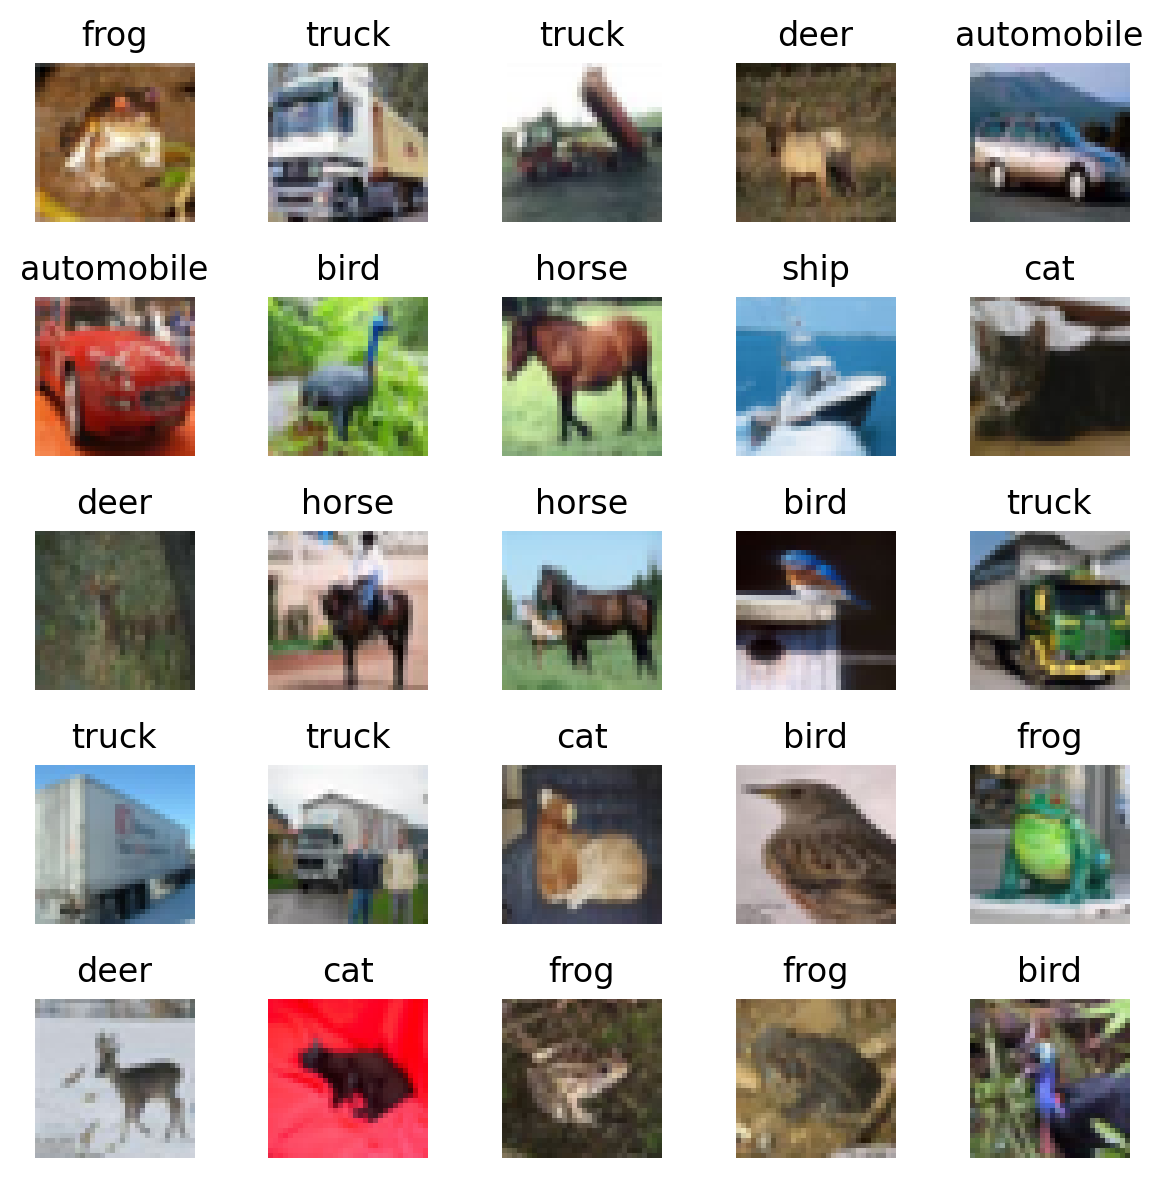

In [5]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()


### Data splitting

In [6]:
n_train = 1000
n_test = 20000

X = dataset.data
y = dataset.targets

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [7]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(f"Length of train set: {len(train_idx)}")
print(f"Length of pool set: {len(pool_idx)}")
print(f"Length of test set: {len(test_idx)}")

Length of train set: 1000
Length of pool set: 39000
Length of test set: 20000


In [8]:
resnet = ResNetClassifier(models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=10).to(device)

/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [9]:
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [10]:
def get_accuracy(net, X, y):
    # Set the net to evaluation mode
    net.eval()
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
    return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f'{name} set accuracy: {acc*100:.2f}%')
        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d'
                                                                                , cmap='Blues')
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()


train set accuracy: 7.70%


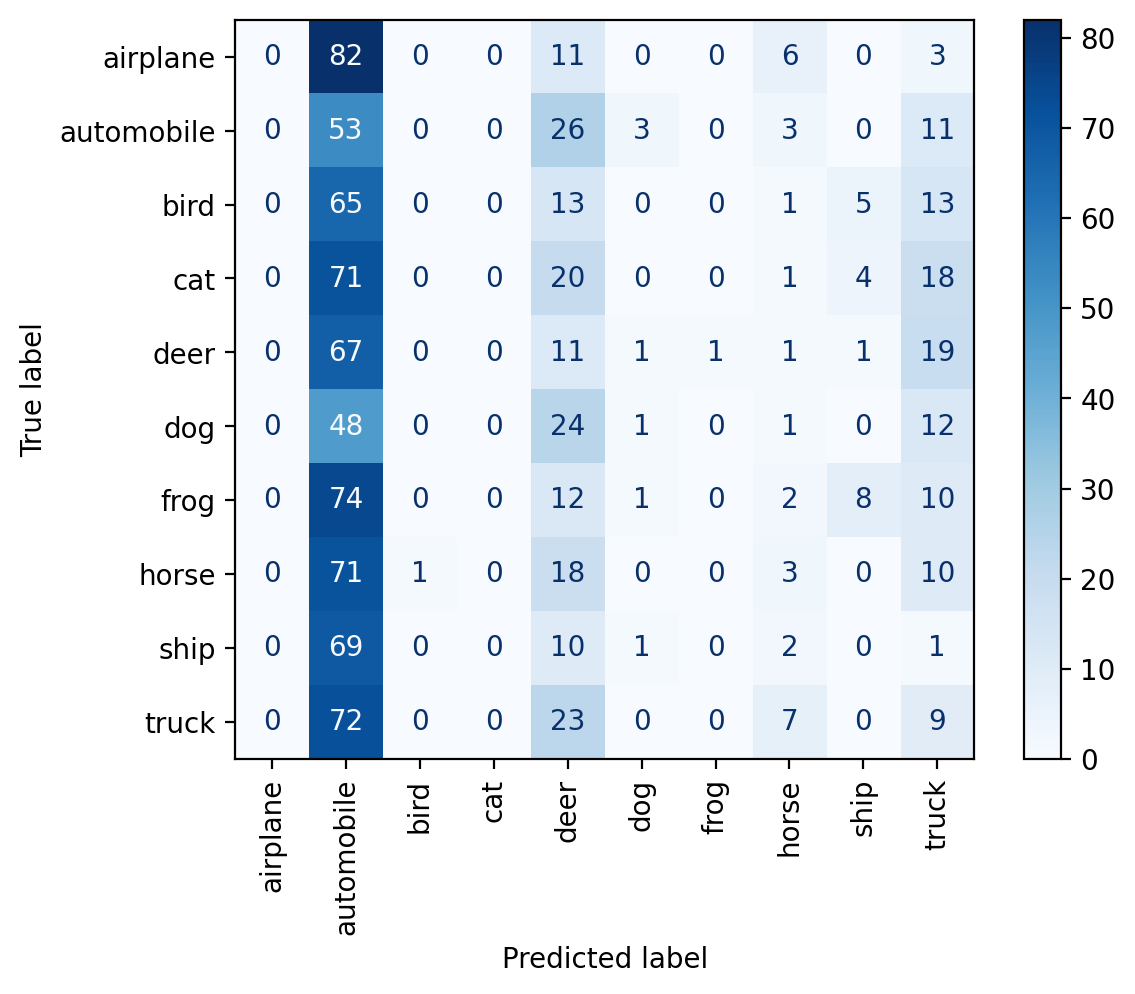

pool set accuracy: 7.57%


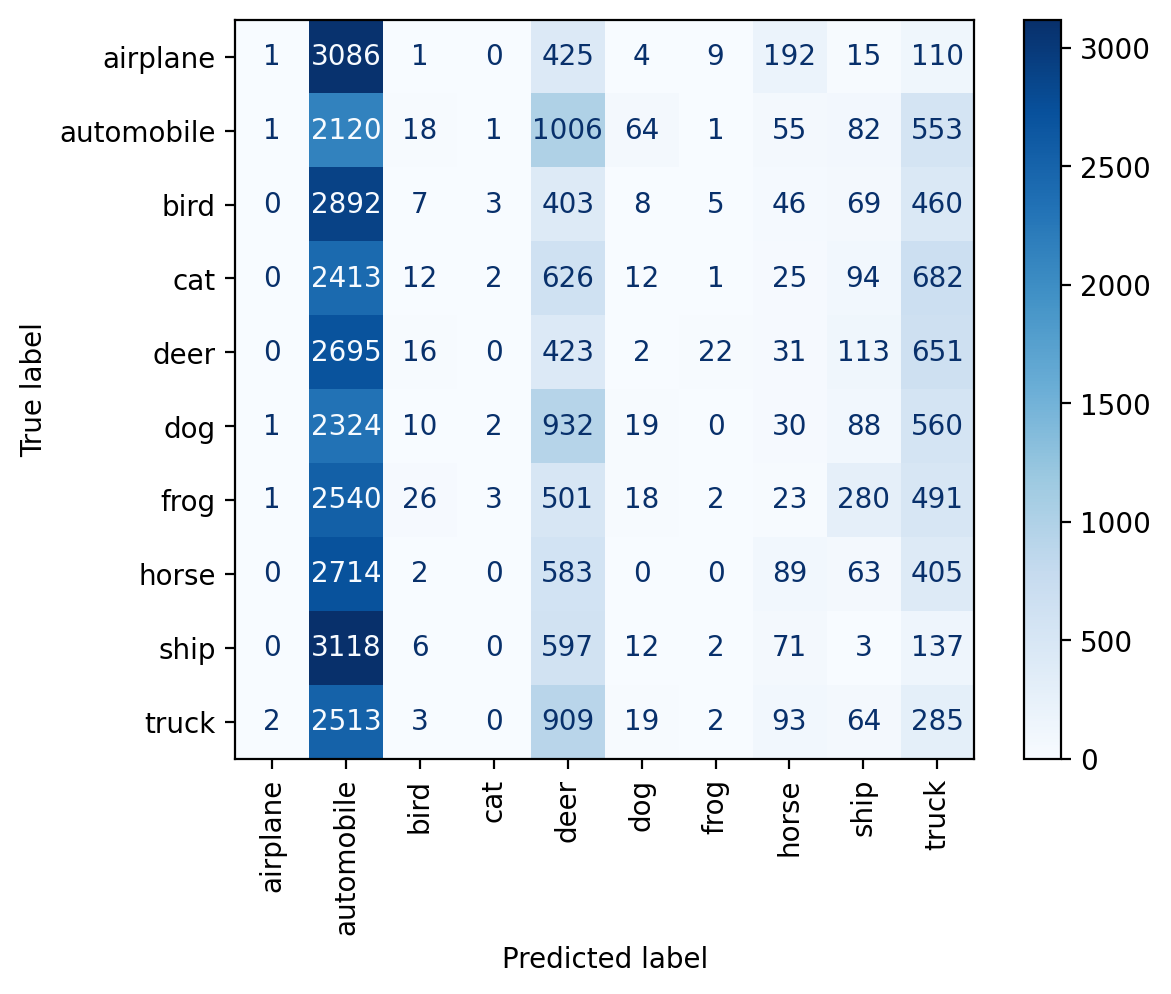

test set accuracy: 7.58%


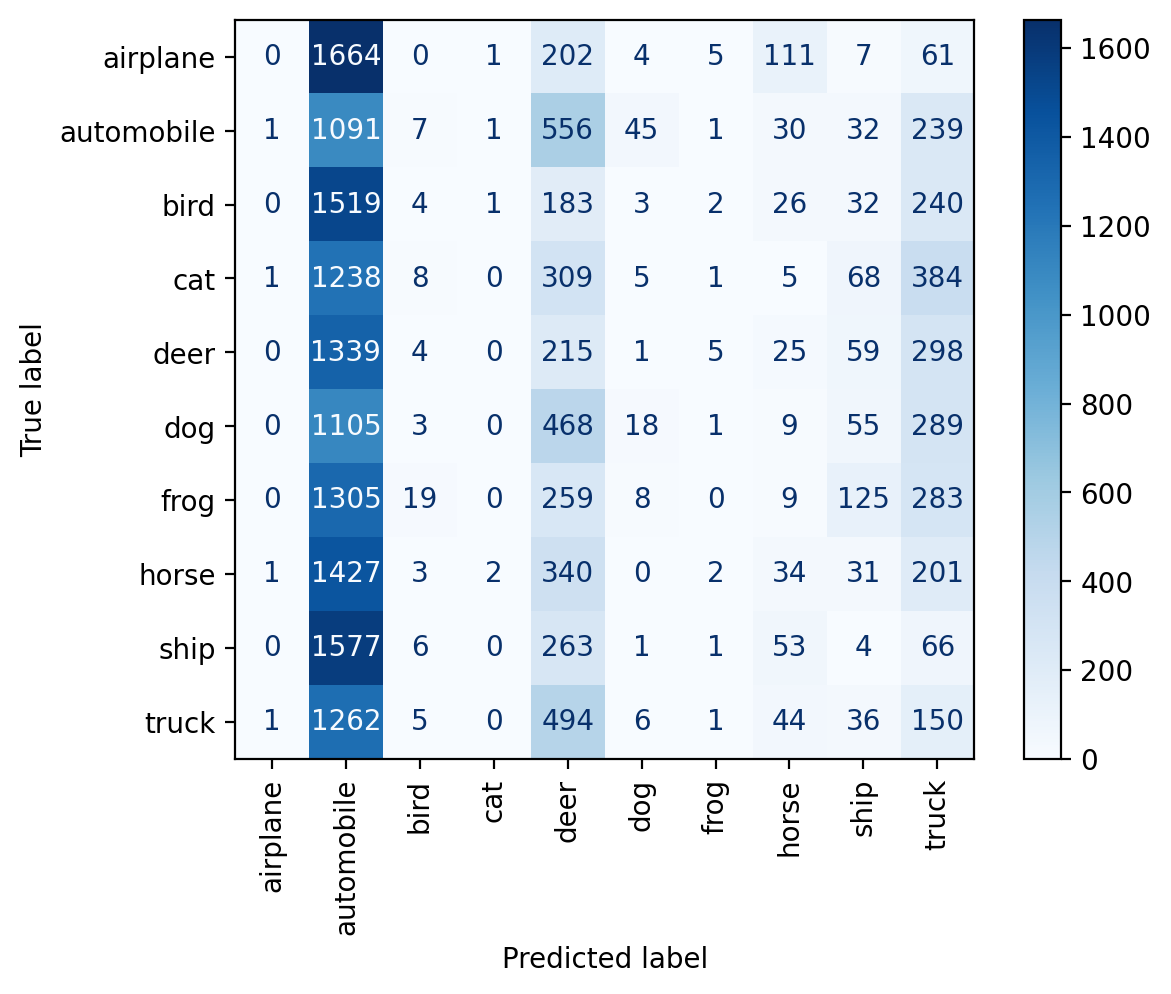

In [11]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

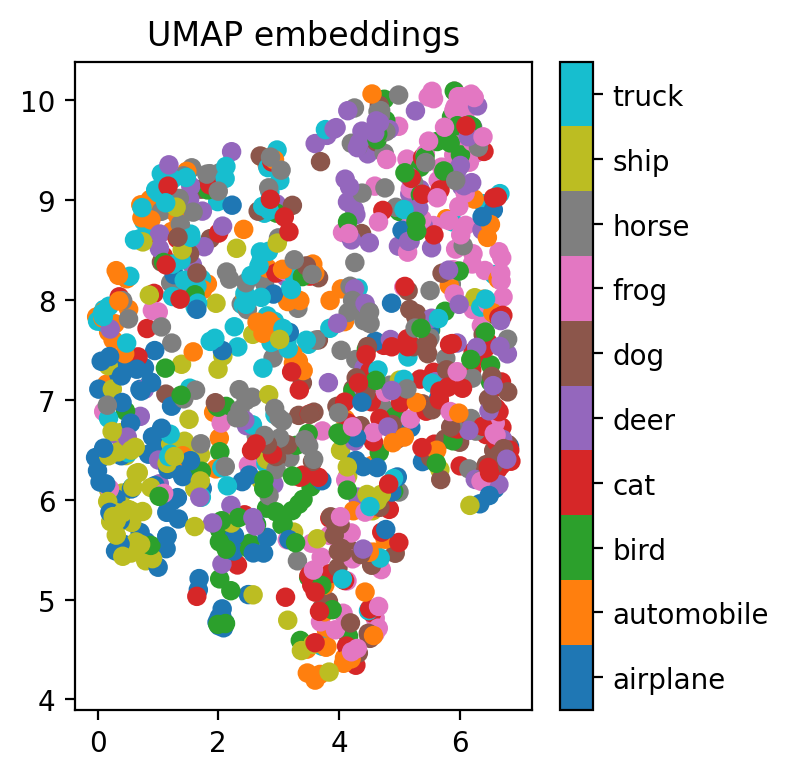

In [12]:
def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')
    # Add a colorbar legend to mark color to class mapping
    cb = plt.colorbar(boundaries=np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()

viz_embeddings(resnet, X[train_idx], y[train_idx], device)

#### Train the model on train set

In [13]:
model_only_train = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
iter_losses, epoch_losses = train_fn(model_only_train, X[train_idx], y[train_idx], nn.CrossEntropyLoss(), lr=3e-4, 
                                     batch_size=128, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

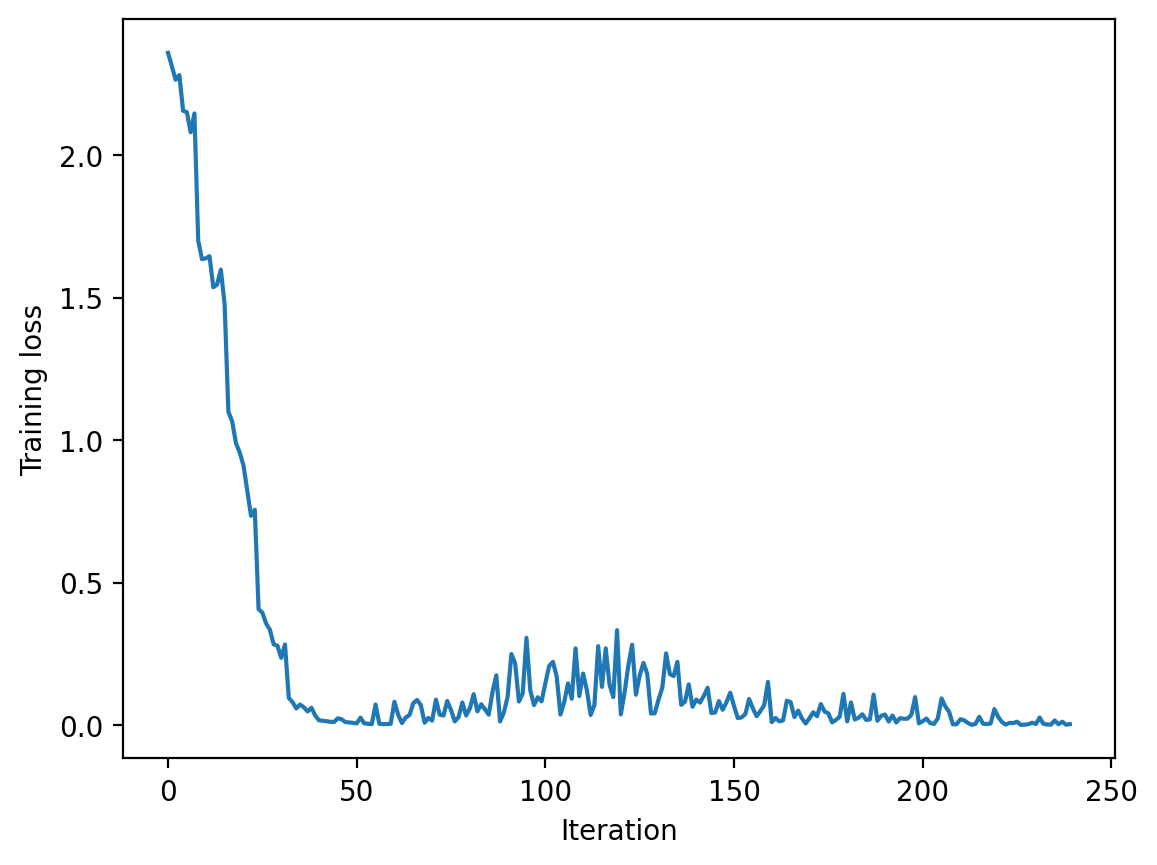

In [14]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%


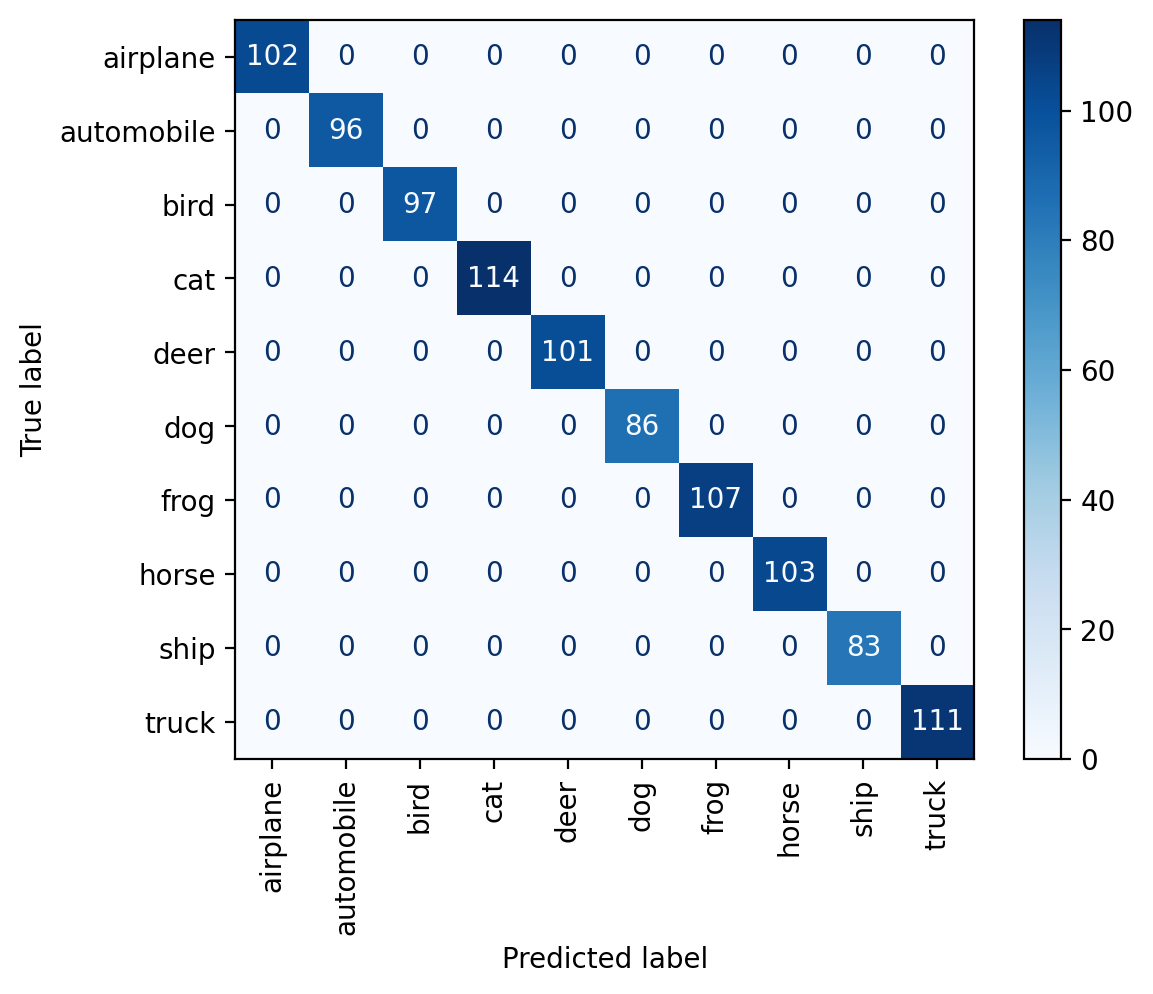

pool set accuracy: 35.53%


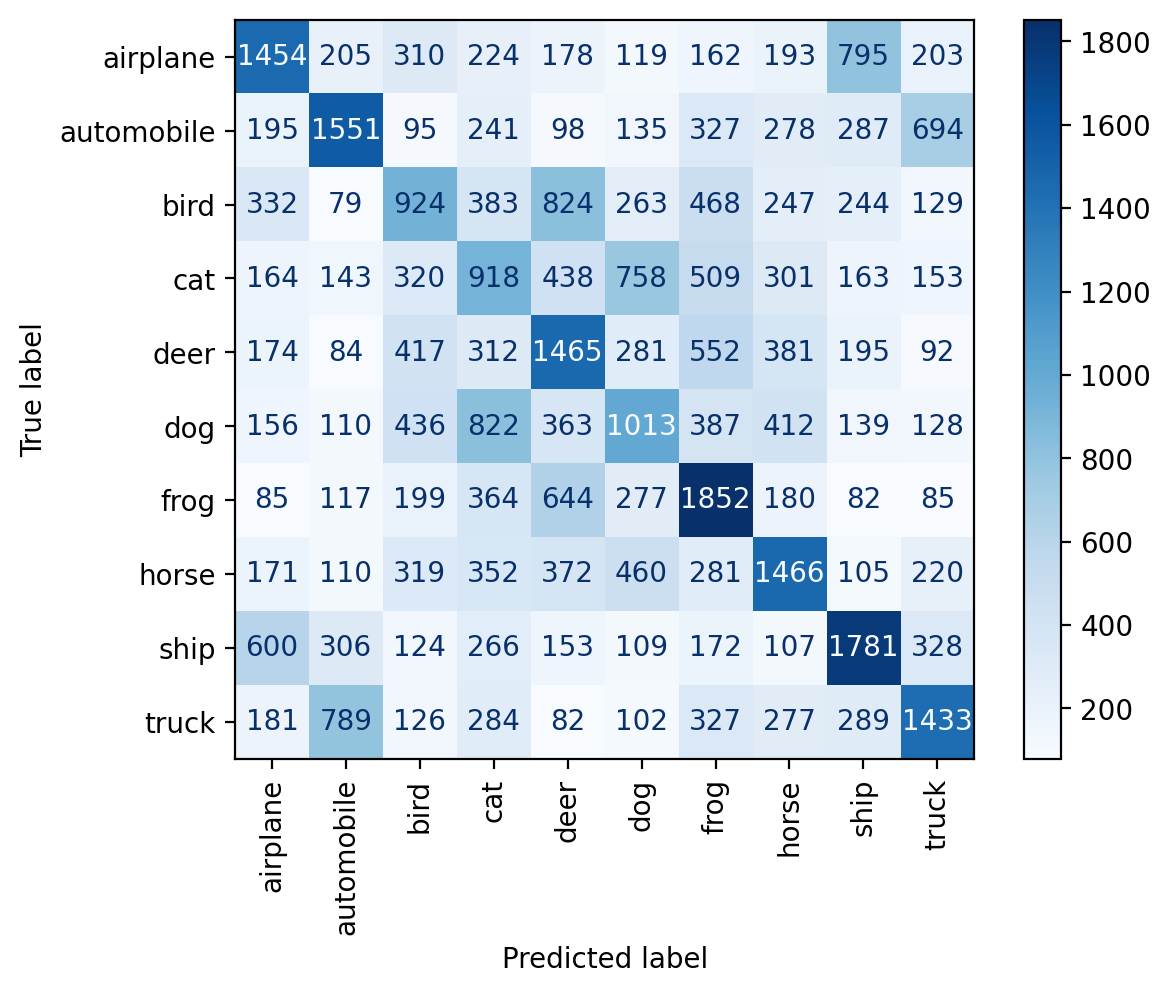

test set accuracy: 35.33%


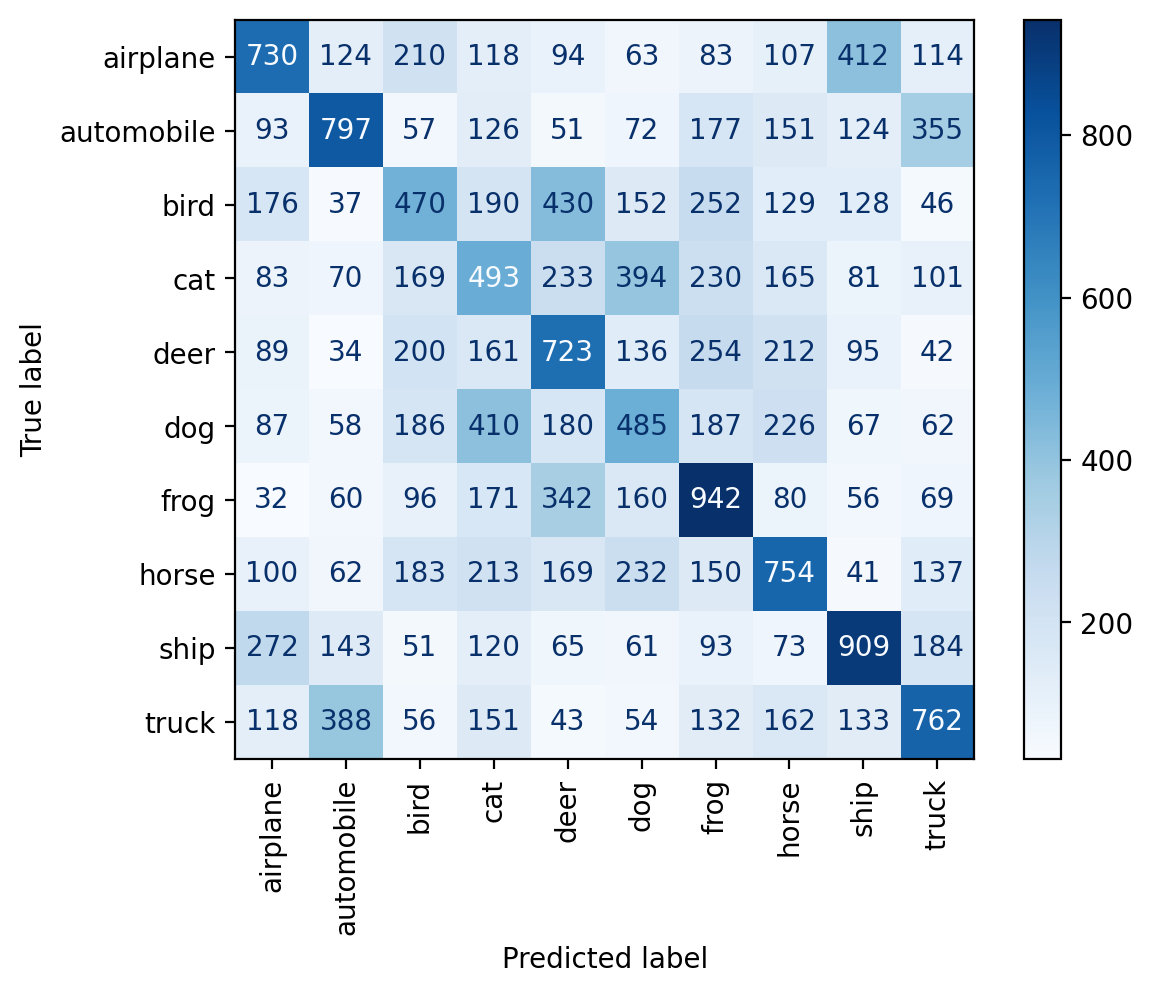

In [15]:
predict(model_only_train, dataset.classes, plot_confusion_matrix=True)

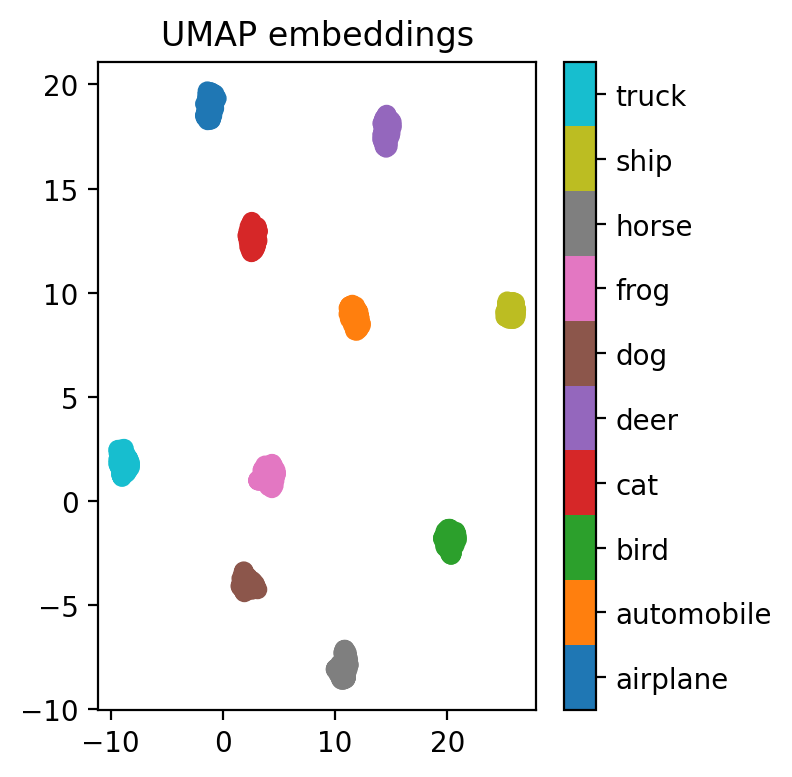

In [16]:
viz_embeddings(model_only_train, X[train_idx], y[train_idx], device)

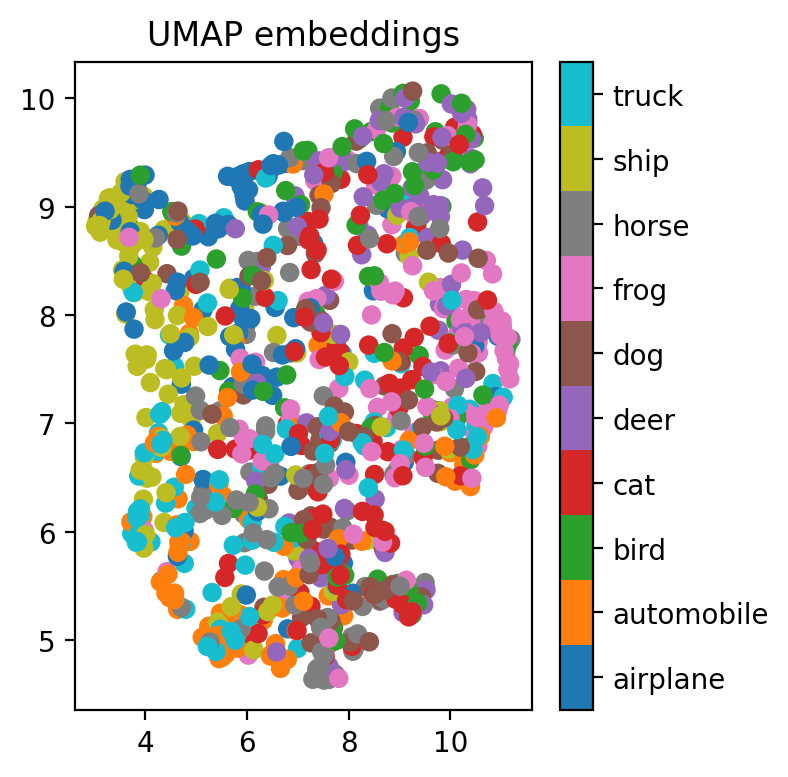

In [17]:
viz_embeddings(model_only_train, X[test_idx[:1000]], y[test_idx[:1000]], device)

### Train on train + pool


In [18]:
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

model_train_plus_pool = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(model_train_plus_pool, X[train_plus_pool_idx], y[train_plus_pool_idx], loss_fn=nn.CrossEntropyLoss(),
                                     lr=3e-4,
                                        batch_size=1024, epochs=30)

Loss: 1.318003: 100%|██████████| 40/40 [00:01<00:00, 33.50it/s]


Epoch 1: 1.636701644897461


Loss: 1.130332: 100%|██████████| 40/40 [00:01<00:00, 35.81it/s]


Epoch 2: 1.2044568725585938


Loss: 0.821397: 100%|██████████| 40/40 [00:01<00:00, 36.25it/s]


Epoch 3: 0.9858628723144531


Loss: 0.779279: 100%|██████████| 40/40 [00:01<00:00, 35.97it/s]


Epoch 4: 0.787159913635254


Loss: 0.862528: 100%|██████████| 40/40 [00:01<00:00, 35.12it/s]


Epoch 5: 0.6295903686523437


Loss: 0.524238: 100%|██████████| 40/40 [00:01<00:00, 36.35it/s]


Epoch 6: 0.5099980773925781


Loss: 0.510165: 100%|██████████| 40/40 [00:01<00:00, 36.51it/s]


Epoch 7: 0.3717664451599121


Loss: 0.423117: 100%|██████████| 40/40 [00:01<00:00, 36.69it/s]


Epoch 8: 0.3031633331298828


Loss: 0.458616: 100%|██████████| 40/40 [00:01<00:00, 36.86it/s]


Epoch 9: 0.29022122650146487


Loss: 0.165772: 100%|██████████| 40/40 [00:01<00:00, 35.59it/s]


Epoch 10: 0.26079437942504885


Loss: 0.087809: 100%|██████████| 40/40 [00:01<00:00, 35.90it/s]


Epoch 11: 0.13630542945861818


Loss: 0.296134: 100%|██████████| 40/40 [00:01<00:00, 35.39it/s]


Epoch 12: 0.1002807499885559


Loss: 0.319740: 100%|██████████| 40/40 [00:01<00:00, 36.15it/s]


Epoch 13: 0.18608614768981935


Loss: 0.301341: 100%|██████████| 40/40 [00:01<00:00, 37.49it/s]


Epoch 14: 0.16239934244155885


Loss: 0.072943: 100%|██████████| 40/40 [00:01<00:00, 36.23it/s]


Epoch 15: 0.14895454578399658


Loss: 0.047622: 100%|██████████| 40/40 [00:01<00:00, 36.49it/s]


Epoch 16: 0.06240539264678955


Loss: 0.031719: 100%|██████████| 40/40 [00:01<00:00, 37.51it/s]


Epoch 17: 0.02642523465156555


Loss: 0.031865: 100%|██████████| 40/40 [00:01<00:00, 35.63it/s]


Epoch 18: 0.026696961951255798


Loss: 0.046578: 100%|██████████| 40/40 [00:01<00:00, 37.41it/s]


Epoch 19: 0.03432212963104248


Loss: 0.066532: 100%|██████████| 40/40 [00:01<00:00, 37.07it/s]


Epoch 20: 0.03469213643074036


Loss: 0.128377: 100%|██████████| 40/40 [00:01<00:00, 35.39it/s]


Epoch 21: 0.07525548481941223


Loss: 0.075391: 100%|██████████| 40/40 [00:01<00:00, 35.56it/s]


Epoch 22: 0.13279609174728393


Loss: 0.180659: 100%|██████████| 40/40 [00:01<00:00, 33.25it/s]


Epoch 23: 0.07557179298400879


Loss: 0.122659: 100%|██████████| 40/40 [00:01<00:00, 36.06it/s]


Epoch 24: 0.08241450214385987


Loss: 0.116485: 100%|██████████| 40/40 [00:01<00:00, 36.39it/s]


Epoch 25: 0.07914679989814759


Loss: 0.216088: 100%|██████████| 40/40 [00:01<00:00, 36.43it/s]


Epoch 26: 0.08806239323616027


Loss: 0.063434: 100%|██████████| 40/40 [00:01<00:00, 36.54it/s]


Epoch 27: 0.11902619647979737


Loss: 0.111266: 100%|██████████| 40/40 [00:01<00:00, 35.95it/s]


Epoch 28: 0.05027928895950318


Loss: 0.039604: 100%|██████████| 40/40 [00:01<00:00, 35.99it/s]


Epoch 29: 0.05692305927276611


Loss: 0.111527: 100%|██████████| 40/40 [00:01<00:00, 36.67it/s]


Epoch 30: 0.03280420844554901


Text(0, 0.5, 'Training loss')

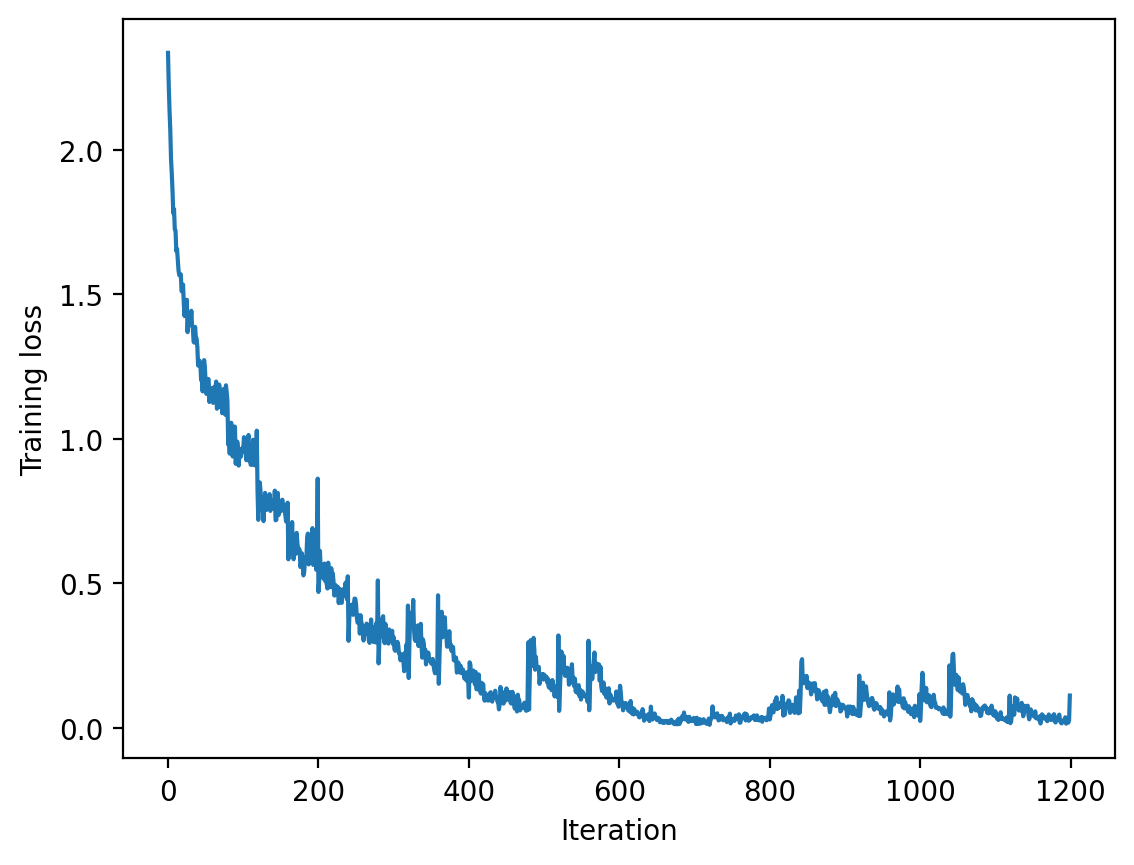

In [19]:
plt.plot(iter_losses)   
plt.xlabel("Iteration")
plt.ylabel("Training loss")

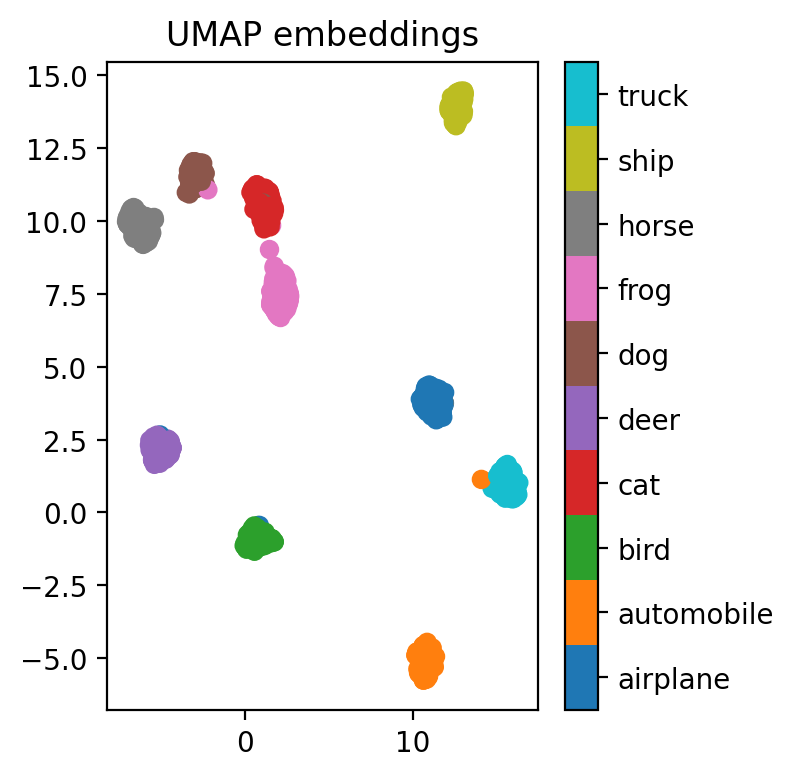

In [20]:
viz_embeddings(model_train_plus_pool, X[train_idx], y[train_idx], device)

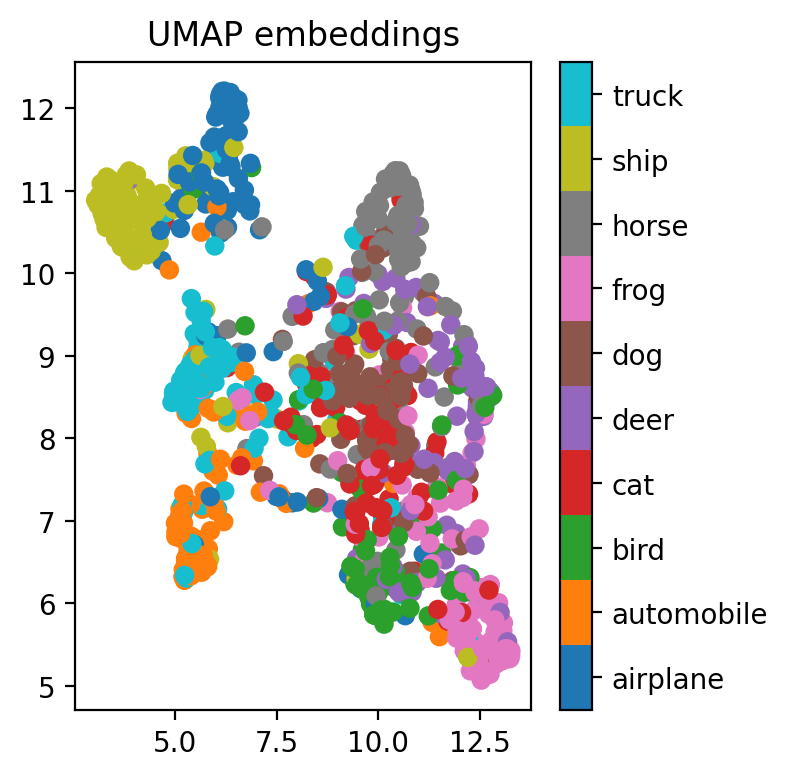

In [21]:
viz_embeddings(model_train_plus_pool, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 97.80%


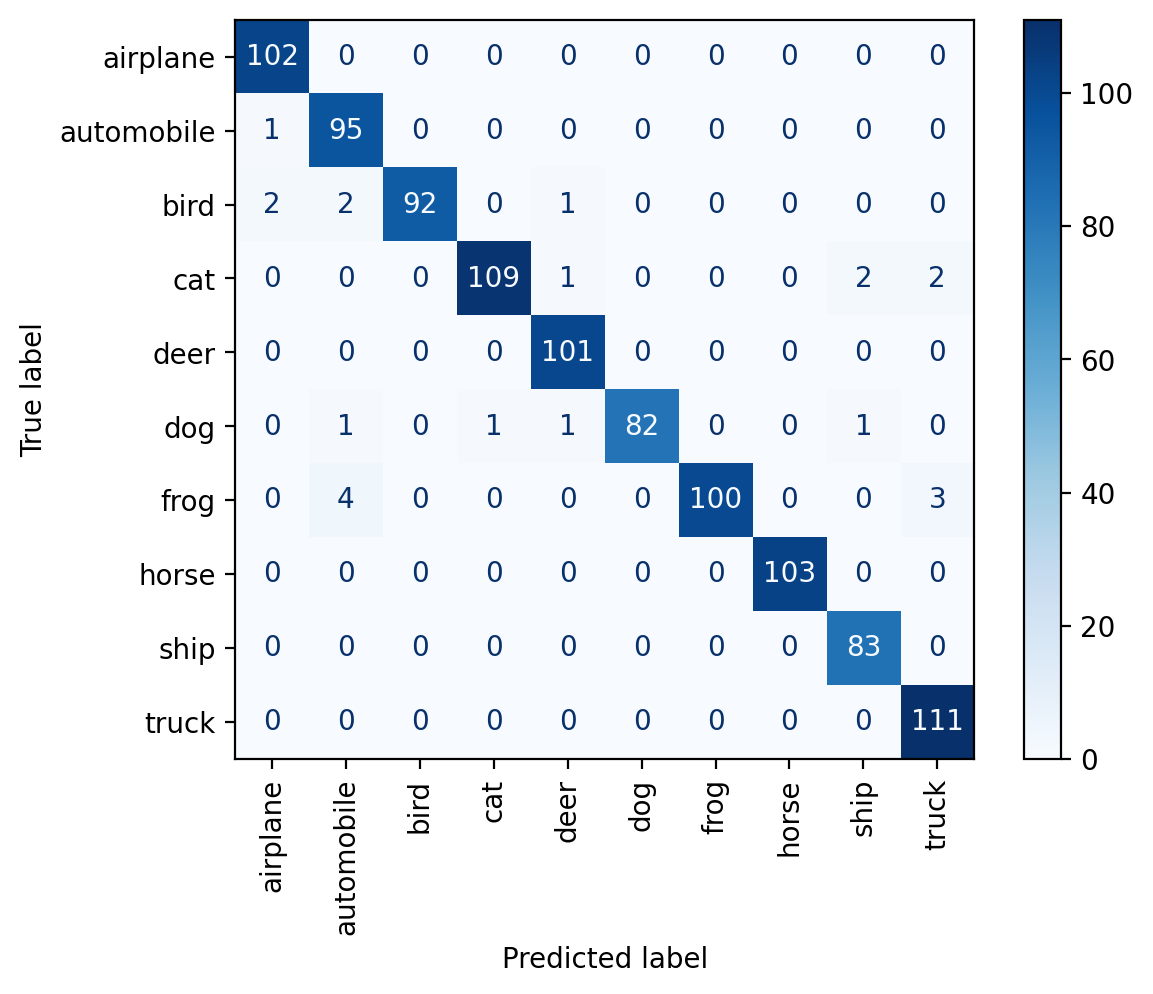

pool set accuracy: 98.03%


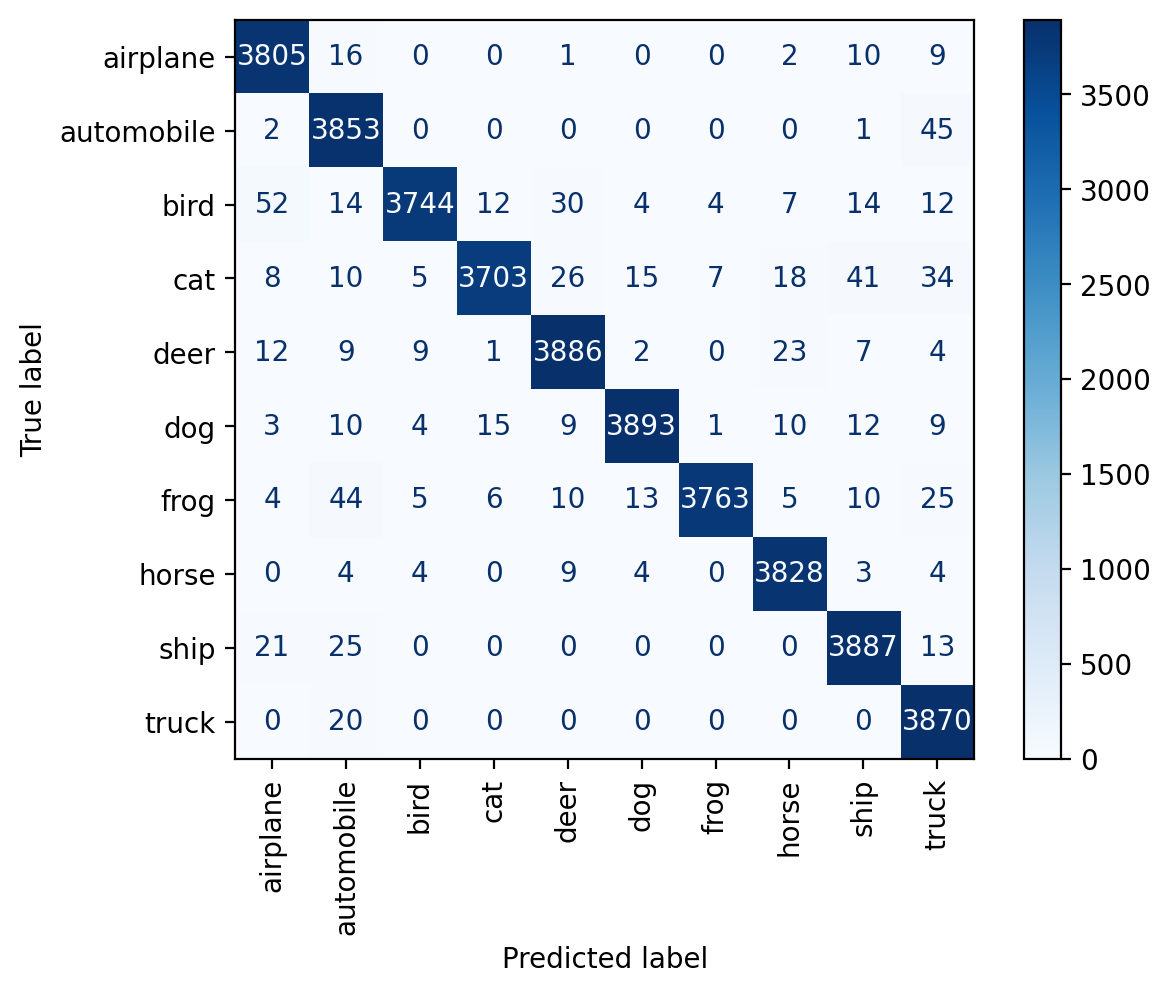

test set accuracy: 61.14%


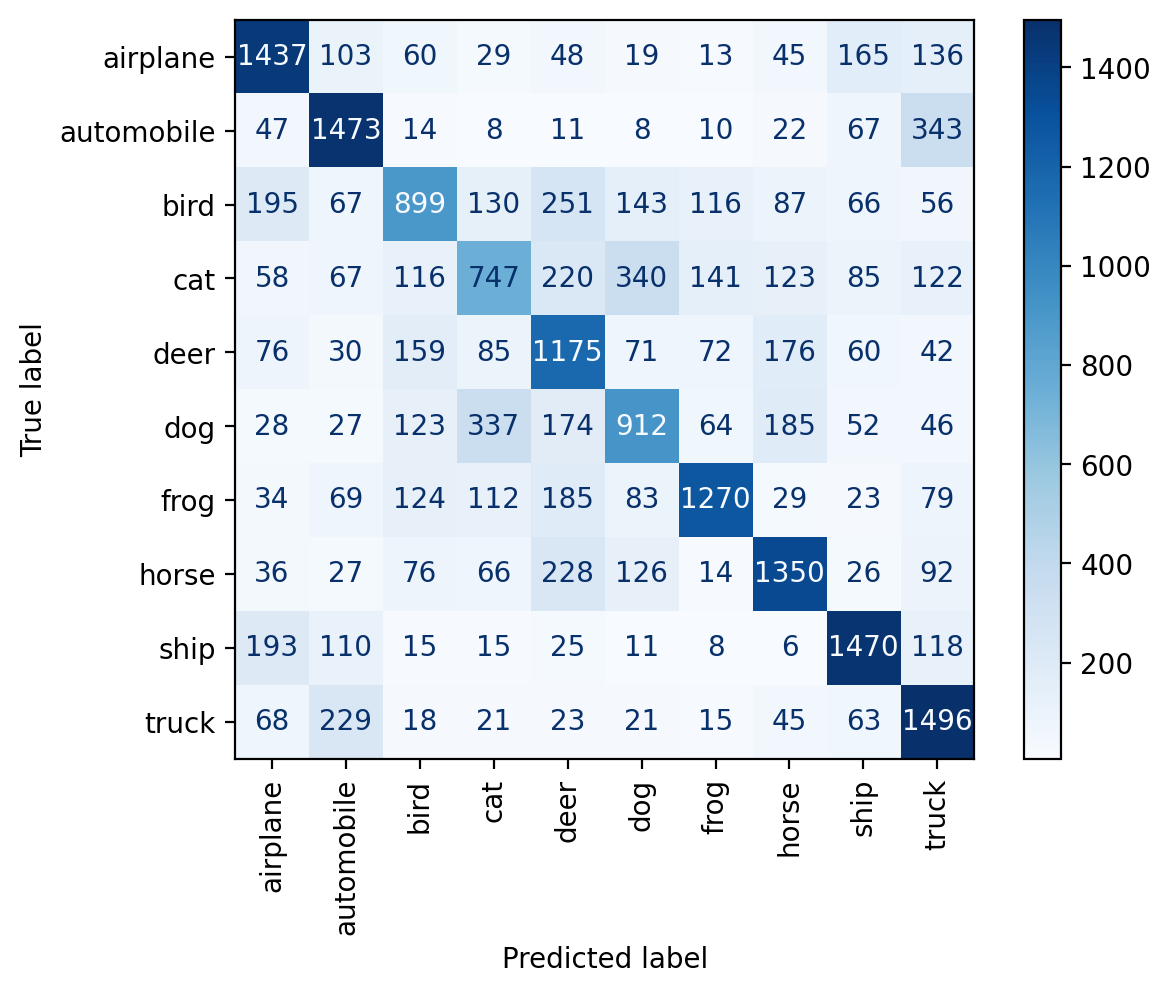

In [22]:
predict(model_train_plus_pool, dataset.classes, plot_confusion_matrix=True)

Text(0, 0.5, 'Accuracy')

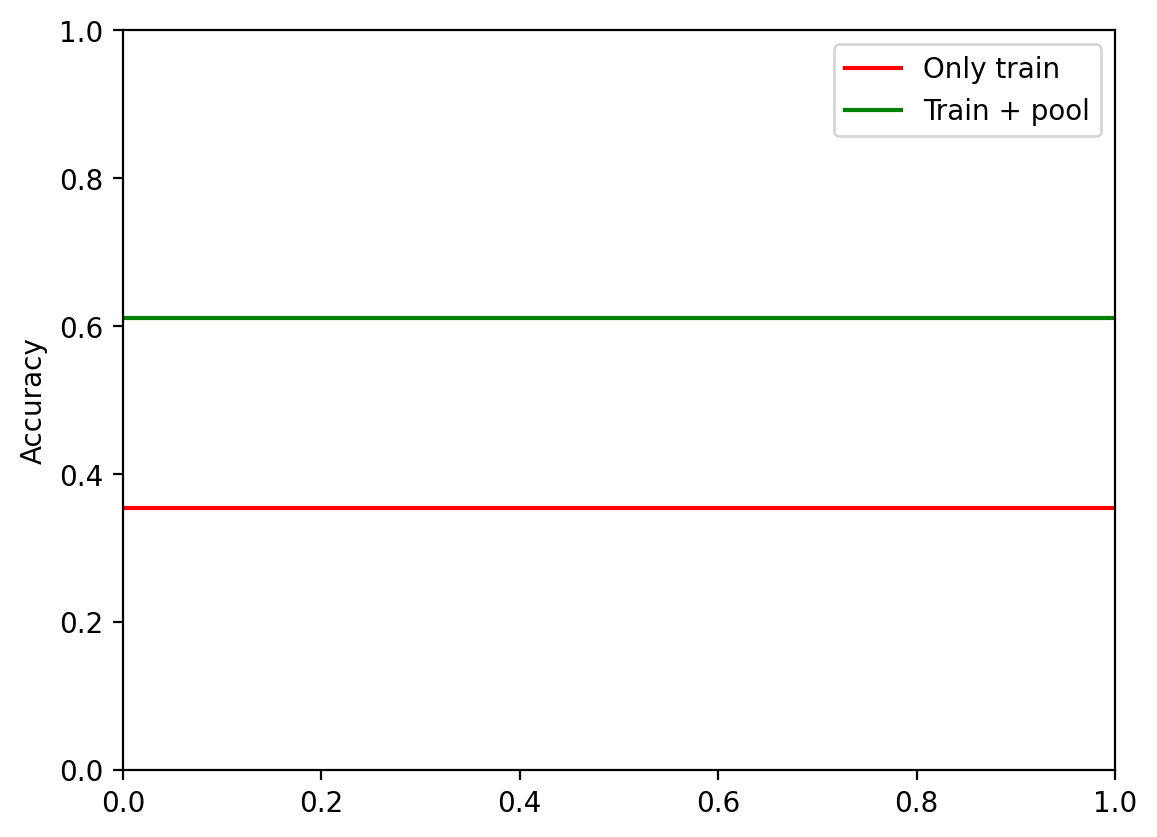

In [23]:
accuracy_only_train = get_accuracy(model_only_train, X[test_idx].to(device), y[test_idx].to(device))[1]
accuracy_train_plus_pool = get_accuracy(model_train_plus_pool, X[test_idx].to(device), y[test_idx].to(device))[1]

plt.axhline(accuracy_only_train.cpu(), color='r', label='Only train')
plt.axhline(accuracy_train_plus_pool.cpu(), color='g', label='Train + pool')
plt.legend()

plt.ylabel("Accuracy")

### Active learning loop



In [24]:
def setdiff1d(a, b):
    mask = ~a.unsqueeze(1).eq(b).any(dim=1)
    return torch.masked_select(a, mask)

a = torch.tensor([1, 2, 3, 4, 5])
b = torch.tensor([1, 3, 5])

print(setdiff1d(a, b))

a = torch.tensor([1, 2, 3, 4, 5])
b = torch.tensor([1, 2, 3, 4, 5])

print(setdiff1d(a, b))

tensor([2, 4])
tensor([], dtype=torch.int64)


In [29]:
def al_loop(model, query_strategy, num_al_iterations, num_epochs_finetune,
            train_idx, pool_idx, test_idx, query_size, 
            X, y, device, random_seed=0, verbose=False):
    """
    model: PyTorch model trained on train_idx
    query_strategy: function that takes in model and pool_idx, 
                train_idx and returns indices to query
    num_al_iterations: number of active learning iterations
    num_epochs_finetune: number of epochs to train on queried data + train_idx
    train_idx: indices of data used for training
    pool_idx: indices of data used for querying
    test_idx: indices of data used for testing
    query_size: number of data points to query at each iteration
    X: data
    y: labels
    device: torch device
    random_seed: random seed
    verbose: print statements
    """
    tr_idx = train_idx.clone()
    p_idx = pool_idx.clone()
    torch.manual_seed(random_seed)
    
    print(f"Initial train size: {train_idx.shape}")
    print(f"Initial pool size: {pool_idx.shape}")
    
    # Initial model test accuracy
    init_accuracy = get_accuracy(model, X[test_idx].to(device), y[test_idx].to(device))[1].item()
    print(f"Test accuracy before AL: {init_accuracy:0.4f}")
    
    # Test accuracies
    test_accuracies = {0: init_accuracy}
    
    for iteration in range(num_al_iterations):
        
        # Query
        model.eval()
        query_idx = query_strategy(model, p_idx, tr_idx, random_seed, query_size, X, y, device)
        # Add queried data to train_idx
        tr_idx = torch.cat([tr_idx, query_idx])
        # Remove queried data from pool_idx
        p_idx = setdiff1d(p_idx, query_idx)
        # Retrain model on pooled data
        iter_losses, epoch_losses = train_fn(model, X[tr_idx], y[tr_idx], loss_fn=nn.CrossEntropyLoss(),
                                             lr=3e-4, batch_size=1024,
                                             epochs=num_epochs_finetune, 
                                             verbose=False)
        test_accuracies[iteration+1] = get_accuracy(model, X[test_idx].to(device), y[test_idx].to(device))[1].item()
        if verbose:
            print(f"Active learning iteration {iteration+1}/{num_al_iterations}")
            print(f"Train set size: {len(tr_idx)}, Pool set size: {len(p_idx)}")
            print(f"Test accuracy: {test_accuracies[iteration]:0.4f}")
            print()
    return model, tr_idx, p_idx, test_accuracies      
    

In [30]:
def random_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    torch.manual_seed(random_seed)
    query_idx = pool_idx[torch.randperm(len(pool_idx))[:query_size]]
    return query_idx

In [31]:
query_size = 20
num_al_iterations = 50

In [32]:

import copy

model_r = copy.deepcopy(model_only_train)

model, t_idx, p_idx, test_acc_random = al_loop(model_r, random_sampling, num_al_iterations, 20, train_idx, pool_idx, test_idx, query_size, X, y,device=device,verbose=True)

Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3532
Active learning iteration 1/50
Train set size: 1020, Pool set size: 38980
Test accuracy: 0.3532

Active learning iteration 2/50
Train set size: 1040, Pool set size: 38960
Test accuracy: 0.3646

Active learning iteration 3/50
Train set size: 1060, Pool set size: 38940
Test accuracy: 0.2930

Active learning iteration 4/50
Train set size: 1080, Pool set size: 38920
Test accuracy: 0.3288

Active learning iteration 5/50
Train set size: 1100, Pool set size: 38900
Test accuracy: 0.3429

Active learning iteration 6/50
Train set size: 1120, Pool set size: 38880
Test accuracy: 0.3391

Active learning iteration 7/50
Train set size: 1140, Pool set size: 38860
Test accuracy: 0.3533

Active learning iteration 8/50
Train set size: 1160, Pool set size: 38840
Test accuracy: 0.3580

Active learning iteration 9/50
Train set size: 1180, Pool set size: 38820
Test accuracy: 0.3529

Active learning i

<Axes: >

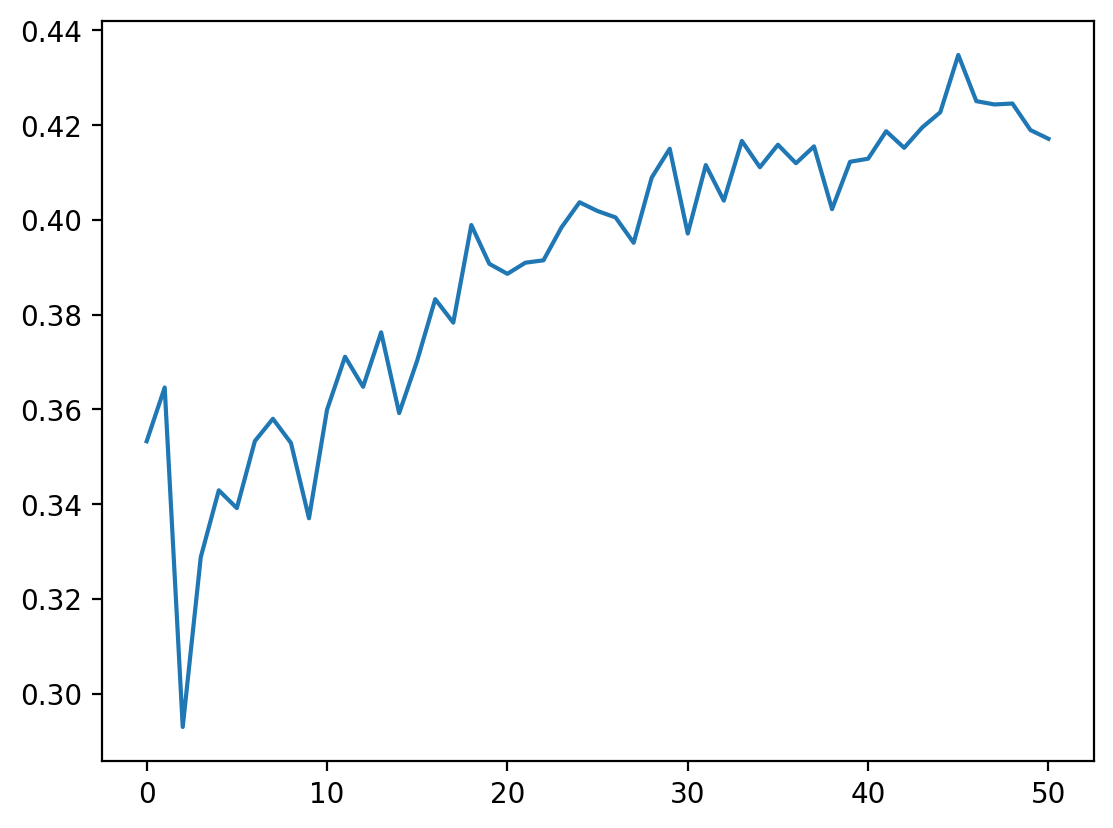

In [33]:
pd.Series(test_acc_random).plot()

In [35]:
### Now, running across multiple random seeds

query_size = 20
num_al_iterations = 50
ms = {}
t_idxs = {}
p_idxs = {}
test_acc_random = {}
for rs in range(5):
    print(f"Random seed: {rs}")
    model = copy.deepcopy(model_only_train)
    ms[rs], t_idxs[rs], p_idxs[rs], test_acc_random[rs] = al_loop(model, random_sampling, num_al_iterations, 20, train_idx, pool_idx, test_idx, query_size, X, y,device=device,verbose=False, random_seed=rs)


Random seed: 0
Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3532
Random seed: 1
Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3532
Random seed: 2
Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3532
Random seed: 3
Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3532
Random seed: 4
Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3532


In [37]:
test_acc_random_df = pd.DataFrame(test_acc_random)
mean_acc = test_acc_random_df.mean(axis=1)
std_acc = test_acc_random_df.std(axis=1)

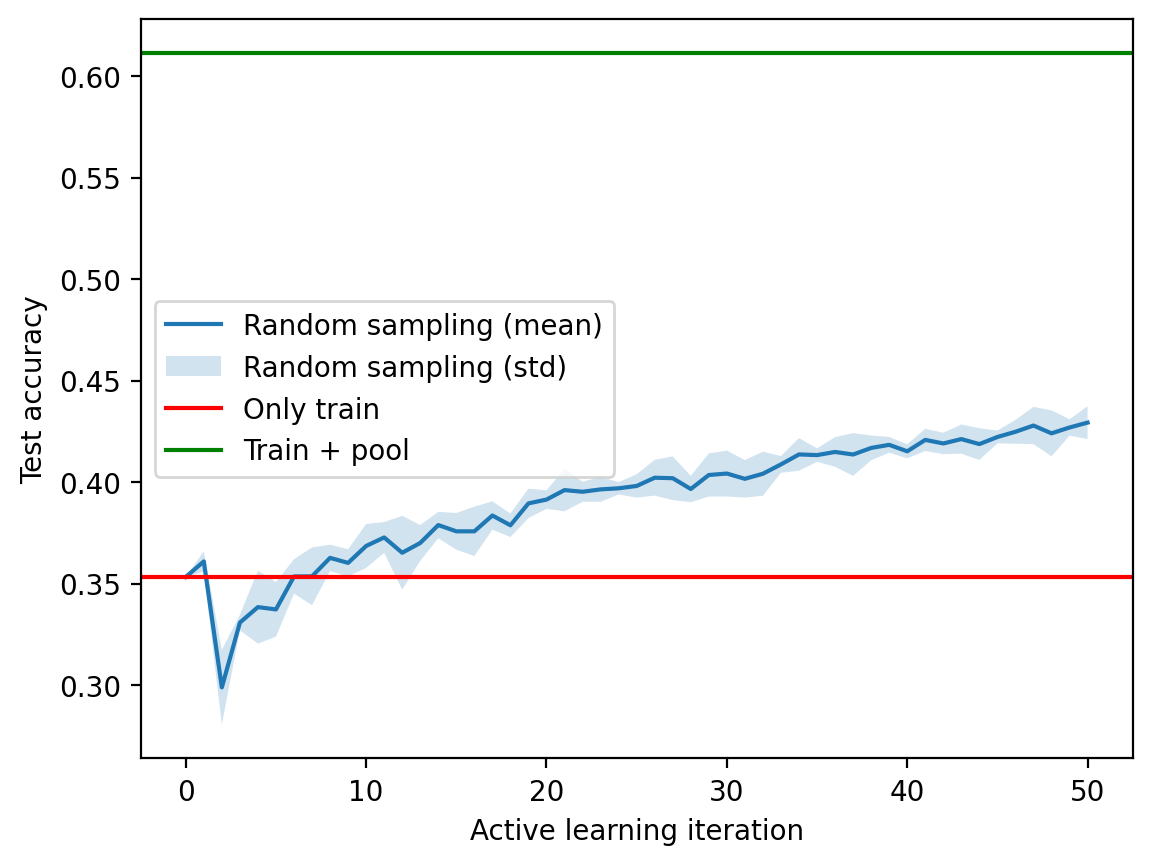

In [38]:
plt.plot(mean_acc, label="Random sampling (mean)")
plt.fill_between(mean_acc.index, mean_acc-std_acc,
                 mean_acc+std_acc, alpha=0.2, label="Random sampling (std)")

# Accuracy of model trained on train_idx
plt.axhline(accuracy_only_train.cpu(), color='r', label='Only train')

# Accuracy of model trained on train_idx + pool_idx
plt.axhline(accuracy_train_plus_pool.cpu(), color='g', label='Train + pool')
plt.xlabel("Active learning iteration")
plt.ylabel("Test accuracy")
plt.legend()

In [41]:
def entropy_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    torch.manual_seed(random_seed)
    with torch.no_grad():
        logits = model(X[pool_idx].to(device)) # (len(pool_idx), n_classes)
        probs = F.softmax(logits, dim=1)
        entropy = torch.sum(-probs * torch.log(probs), dim=1)
        entropy_sorted = entropy.sort(descending=True)
        query_idx = pool_idx.to(device)[entropy_sorted.indices[:query_size]]
    return query_idx.cpu()

In [42]:
entropy_sampling(model_only_train, pool_idx, train_idx, 0, 5, X, y, device)

tensor([ 2946, 45792, 47575, 31607, 56040])

In [43]:
model_e = copy.deepcopy(model_only_train)
# AL loop

m, p_idx, t_idx, test_acc_entropy  = al_loop(model_e, entropy_sampling, num_al_iterations, 20, train_idx, pool_idx, test_idx, query_size, 
                                             X, y,device=device,verbose=True, random_seed=0)

Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3532
Active learning iteration 1/50
Train set size: 1020, Pool set size: 38980
Test accuracy: 0.3532

Active learning iteration 2/50
Train set size: 1040, Pool set size: 38960
Test accuracy: 0.3591

Active learning iteration 3/50
Train set size: 1060, Pool set size: 38940
Test accuracy: 0.3174

Active learning iteration 4/50
Train set size: 1080, Pool set size: 38920
Test accuracy: 0.3345

Active learning iteration 5/50
Train set size: 1100, Pool set size: 38900
Test accuracy: 0.3158

Active learning iteration 6/50
Train set size: 1120, Pool set size: 38880
Test accuracy: 0.3662

Active learning iteration 7/50
Train set size: 1140, Pool set size: 38860
Test accuracy: 0.3424

Active learning iteration 8/50
Train set size: 1160, Pool set size: 38840
Test accuracy: 0.3477

Active learning iteration 9/50
Train set size: 1180, Pool set size: 38820
Test accuracy: 0.3511

Active learning i

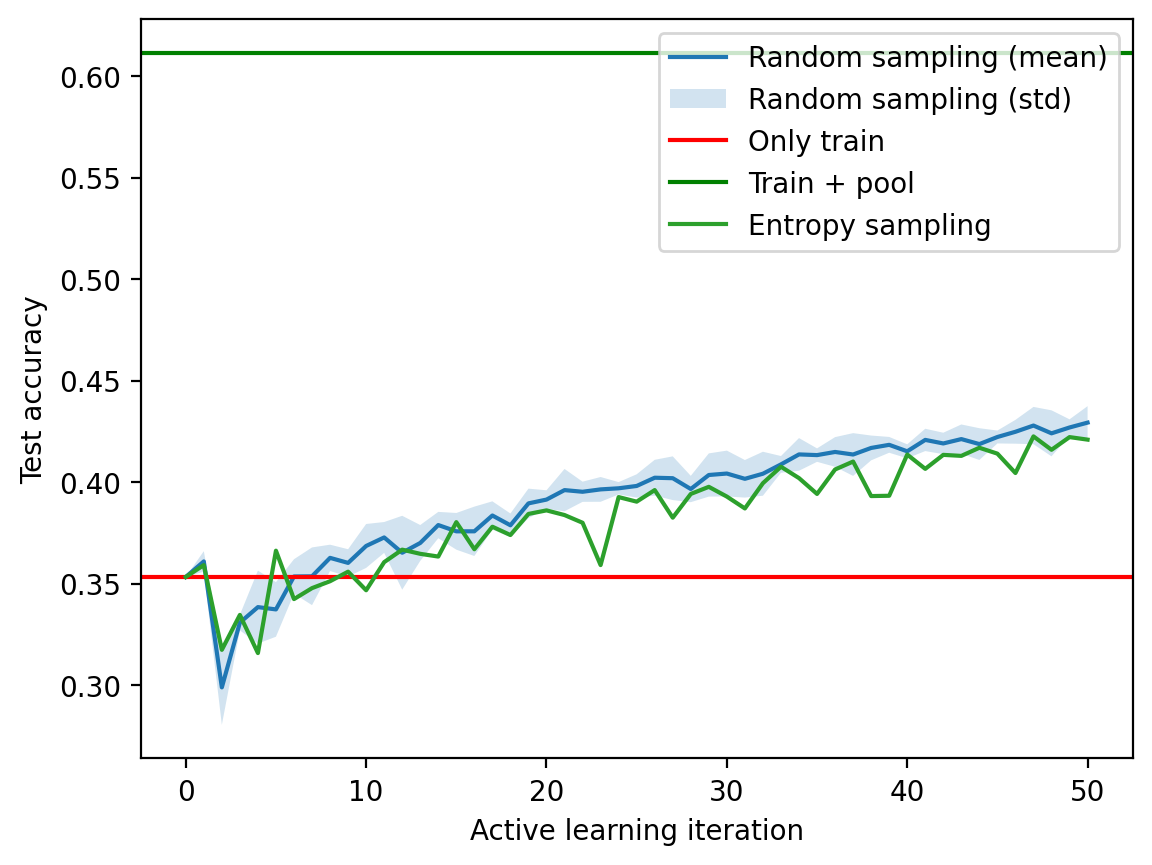

In [102]:
fig, ax = plt.subplots(1, 1)
ax.plot(mean_acc, label="Random sampling (mean)")
ax.fill_between(mean_acc.index, mean_acc-std_acc,
                 mean_acc+std_acc, alpha=0.2, label="Random sampling (std)")
ax.axhline(accuracy_only_train.cpu(), color='r', label='Only train')
ax.axhline(accuracy_train_plus_pool.cpu(), color='g', label='Train + pool')

pd.Series(test_acc_entropy).plot(ax=ax, label="Entropy sampling", color='C2')

ax.set_xlabel("Active learning iteration")
ax.set_ylabel("Test accuracy")
ax.legend()

In [45]:
def margin_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    torch.manual_seed(random_seed)
    with torch.no_grad():
        logits = model(X[pool_idx].to(device))    
        probs = F.softmax(logits, dim=1)
        margin = torch.topk(probs, 2, dim=1).values
        margin = margin[:, 0] - margin[:, 1]
        margin_sorted = margin.sort(descending=True)
        query_idx = pool_idx.to(device)[margin_sorted.indices[:query_size]]
    return query_idx.cpu()

In [46]:
margin_sampling(model_only_train, pool_idx, train_idx, 0, 5, X, y, device)

tensor([36785, 51553,  1668, 53790, 28164])

In [47]:
def diversity_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    torch.manual_seed(random_seed)
    with torch.no_grad():
        emb_pool = model.featurizer(X[pool_idx].to(device))
        emb_train = model.featurizer(X[train_idx].to(device))
        # Find the distance between each pool point and each train point
        dist = torch.cdist(emb_pool, emb_train)
        print(dist.shape)
        # Find the minimum distance for each pool point
        min_dist = dist.min(dim=1).values
        print(min_dist)
        # Sort the pool points by minimum distance
        min_dist_sorted = min_dist.sort(descending=True)
        query_idx = pool_idx.to(device)[min_dist_sorted.indices[:query_size]]
    return query_idx.cpu()
        

In [48]:
diversity_sampling(model_only_train, pool_idx, train_idx, 0, 5, X, y, device)

torch.Size([39000, 1000])
tensor([20.9841, 14.6172, 21.3995,  ..., 22.9982, 18.0180, 20.0437],
       device='cuda:0')


tensor([40154, 26018, 15418, 18260, 43270])

In [85]:
# BALD sample dataset to illustrate the idea

pred_A = torch.tensor([0.5]*10).reshape(-1, 1, 1).repeat(1, 1, 2)
print(pred_A.shape)
print(pred_A)

torch.Size([10, 1, 2])
tensor([[[0.5000, 0.5000]],

        [[0.5000, 0.5000]],

        [[0.5000, 0.5000]],

        [[0.5000, 0.5000]],

        [[0.5000, 0.5000]],

        [[0.5000, 0.5000]],

        [[0.5000, 0.5000]],

        [[0.5000, 0.5000]],

        [[0.5000, 0.5000]],

        [[0.5000, 0.5000]]])


In [93]:
pred_B = torch.tensor([[0.0, 1.0], [1.0, 0.0]]).repeat(5, 1).reshape(10, 1, 2)
print(pred_B.shape)
print(pred_B)

torch.Size([10, 1, 2])
tensor([[[0., 1.]],

        [[1., 0.]],

        [[0., 1.]],

        [[1., 0.]],

        [[0., 1.]],

        [[1., 0.]],

        [[0., 1.]],

        [[1., 0.]],

        [[0., 1.]],

        [[1., 0.]]])


In [94]:
def BALD_score(logits):
    """
    logits: (n_MC_passes, n_samples, n_classes)
    """
    probs = F.softmax(logits, dim=2)
    expected_probs = probs.mean(dim=0) # Expectation over MC passes
    if bald_verbose:
        print(probs.shape)
        print(expected_probs.shape)
    entropy_expected_probs = torch.sum(-expected_probs * torch.log(expected_probs), dim=1)
    if bald_verbose:
        print(entropy_expected_probs.shape)
    
    entropy_probs = torch.sum(-probs * torch.log(probs), dim=2)
    if bald_verbose:
        print(entropy_probs.shape)
    expected_entropy_probs = entropy_probs.mean(dim=0)
    if bald_verbose:
        print(expected_entropy_probs.shape)
    
    bald_score = entropy_expected_probs - expected_entropy_probs
    if bald_verbose:
        print(bald_score.shape)
    return bald_score

In [95]:
bald_verbose = True
s = BALD_score(torch.rand(100, 5, 3))

torch.Size([100, 5, 3])
torch.Size([5, 3])
torch.Size([5])
torch.Size([100, 5])
torch.Size([5])
torch.Size([5])


In [98]:
bald_verbose = False

# Entropy
entropy_A = torch.sum(-pred_A.mean(dim=0) * torch.log(pred_A.mean(dim=0)), dim=1)
entropy_B = torch.sum(-pred_B.mean(dim=0) * torch.log(pred_B.mean(dim=0)), dim=1)

print(entropy_A)
print(entropy_B)

tensor([0.6931])
tensor([0.6931])


In [99]:
print(BALD_score(pred_A))
print(BALD_score(pred_B))

tensor([0.])
tensor([0.1109])


In [68]:
def BALD_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    """
    model: MC dropout model
    """
    
    # Evaluate the logits on the pool set for each MC pass
    n_MC_passes = 8
    logits = []
    model.train()
    with torch.no_grad():
        for mc_pass in range(n_MC_passes):
            # Set mode of model for MC dropout
            logits.append(model(X[pool_idx].to(device)))
    logits = torch.stack(logits)
    # print(logits.shape)
    bald_score = BALD_score(logits)
    bald_score_sorted = bald_score.sort(descending=True)
    query_idx = pool_idx.to(device)[bald_score_sorted.indices[:query_size]]
    return query_idx.cpu()

In [69]:
z = BALD_sampling(model_only_train, pool_idx, train_idx, 0, 5, X, y, device)

torch.Size([8, 39000, 10])
torch.Size([39000, 10])
torch.Size([39000])
torch.Size([8, 39000])
torch.Size([39000])
torch.Size([39000])


In [70]:
model_e = copy.deepcopy(model_only_train)
# AL loop

m, p_idx, t_idx, test_acc_margin  = al_loop(model_e, margin_sampling, num_al_iterations, 20, train_idx, pool_idx, test_idx, query_size, X, y,device=device,verbose=True, random_seed=0)

Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3521
Active learning iteration 1/50
Train set size: 1020, Pool set size: 38980
Test accuracy: 0.3521

Active learning iteration 2/50
Train set size: 1040, Pool set size: 38960
Test accuracy: 0.3510

Active learning iteration 3/50
Train set size: 1060, Pool set size: 38940
Test accuracy: 0.2814

Active learning iteration 4/50
Train set size: 1080, Pool set size: 38920
Test accuracy: 0.3350

Active learning iteration 5/50
Train set size: 1100, Pool set size: 38900
Test accuracy: 0.3204

Active learning iteration 6/50
Train set size: 1120, Pool set size: 38880
Test accuracy: 0.3264

Active learning iteration 7/50
Train set size: 1140, Pool set size: 38860
Test accuracy: 0.3409

Active learning iteration 8/50
Train set size: 1160, Pool set size: 38840
Test accuracy: 0.3454

Active learning iteration 9/50
Train set size: 1180, Pool set size: 38820
Test accuracy: 0.3625

Active learning i

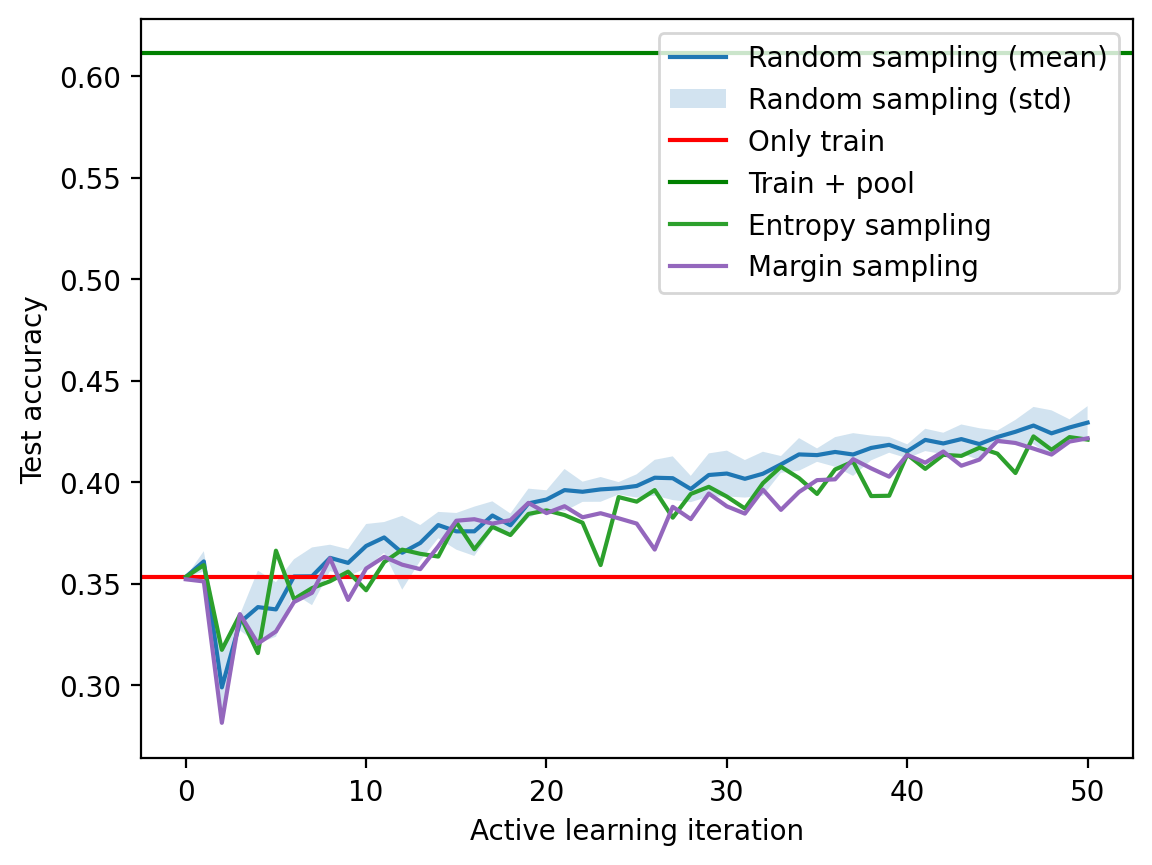

In [104]:
fig, ax = plt.subplots(1, 1)
ax.plot(mean_acc, label="Random sampling (mean)")
ax.fill_between(mean_acc.index, mean_acc-std_acc,
                 mean_acc+std_acc, alpha=0.2, label="Random sampling (std)")
ax.axhline(accuracy_only_train.cpu(), color='r', label='Only train')
ax.axhline(accuracy_train_plus_pool.cpu(), color='g', label='Train + pool')

pd.Series(test_acc_entropy).plot(ax=ax, label="Entropy sampling", color='C2')
pd.Series(test_acc_margin).plot(ax=ax, label="Margin sampling", color='C4')

ax.set_xlabel("Active learning iteration")
ax.set_ylabel("Test accuracy")
ax.legend()

In [65]:
model_e = copy.deepcopy(model_only_train)
# AL loop

m, p_idx, t_idx, test_acc_diversity  = al_loop(model_e, diversity_sampling, num_al_iterations, 20, train_idx, pool_idx, test_idx, query_size, X, y,device=device,verbose=True, random_seed=0)

Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3542
torch.Size([39000, 1000])
tensor([23.6742, 16.5322, 23.8433,  ..., 25.6275, 19.5198, 21.9679],
       device='cuda:0')
Active learning iteration 1/50
Train set size: 1020, Pool set size: 38980
Test accuracy: 0.3542

torch.Size([38980, 1020])
tensor([22.4518, 17.6675, 18.1893,  ..., 20.2362, 19.4250, 20.4936],
       device='cuda:0')
Active learning iteration 2/50
Train set size: 1040, Pool set size: 38960
Test accuracy: 0.3567

torch.Size([38960, 1040])
tensor([18.6880, 14.2518, 21.2189,  ..., 23.0635, 16.1121, 19.2636],
       device='cuda:0')
Active learning iteration 3/50
Train set size: 1060, Pool set size: 38940
Test accuracy: 0.2866

torch.Size([38940, 1060])
tensor([19.6873, 18.1151, 18.7516,  ..., 22.0924, 15.2531, 17.8292],
       device='cuda:0')
Active learning iteration 4/50
Train set size: 1080, Pool set size: 38920
Test accuracy: 0.3207

torch.Size([38920, 1080])


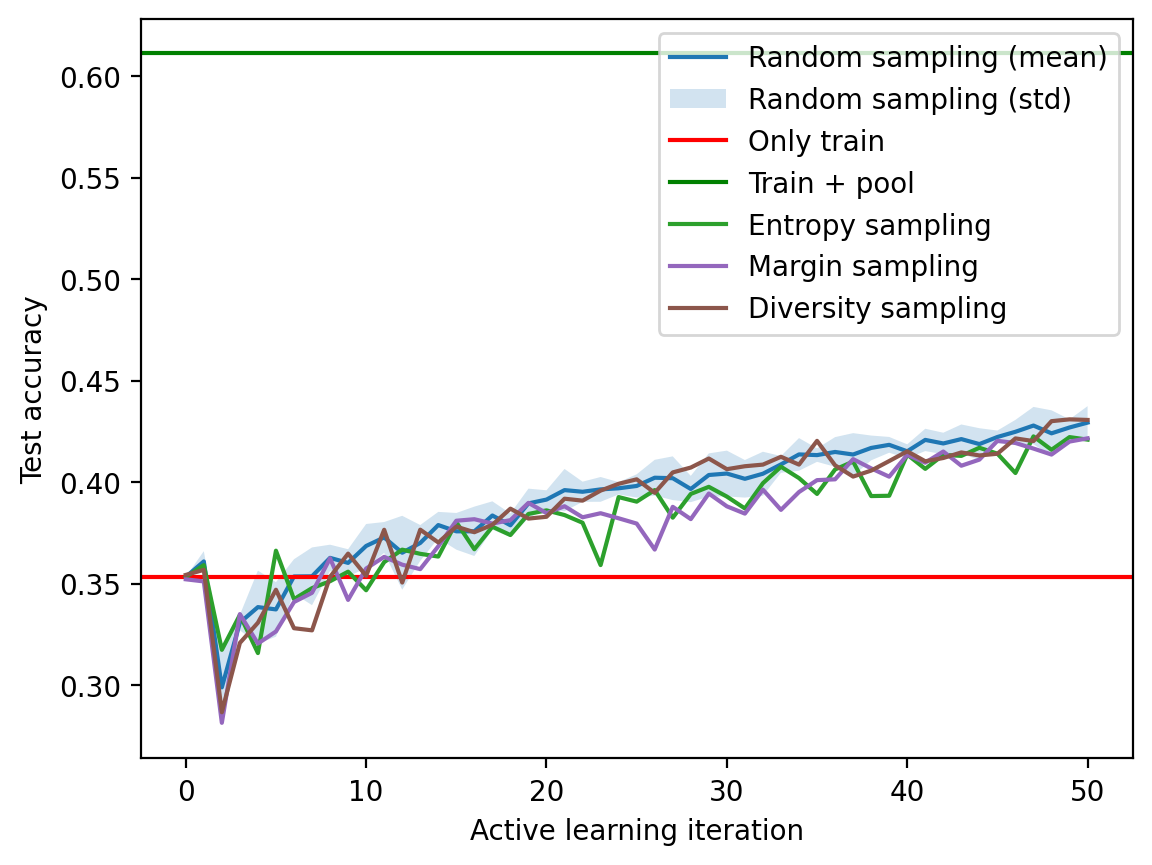

In [105]:
fig, ax = plt.subplots(1, 1)
ax.plot(mean_acc, label="Random sampling (mean)")
ax.fill_between(mean_acc.index, mean_acc-std_acc,
                 mean_acc+std_acc, alpha=0.2, label="Random sampling (std)")
ax.axhline(accuracy_only_train.cpu(), color='r', label='Only train')
ax.axhline(accuracy_train_plus_pool.cpu(), color='g', label='Train + pool')

pd.Series(test_acc_entropy).plot(ax=ax, label="Entropy sampling", color='C2')
pd.Series(test_acc_margin).plot(ax=ax, label="Margin sampling", color='C4')
pd.Series(test_acc_diversity).plot(ax=ax, label="Diversity sampling", color='C5')

ax.set_xlabel("Active learning iteration")
ax.set_ylabel("Test accuracy")
ax.legend()

In [75]:
bald_verbose = False
model_e = copy.deepcopy(model_only_train)
# AL loop

m, p_idx, t_idx, test_acc_bald  = al_loop(model_e, BALD_sampling, num_al_iterations, 20, train_idx, pool_idx, test_idx, query_size, X, y,device=device,verbose=True, random_seed=0)

Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3521
Active learning iteration 1/50
Train set size: 1020, Pool set size: 38980
Test accuracy: 0.3521

Active learning iteration 2/50
Train set size: 1040, Pool set size: 38960
Test accuracy: 0.3523

Active learning iteration 3/50
Train set size: 1060, Pool set size: 38940
Test accuracy: 0.3150

Active learning iteration 4/50
Train set size: 1080, Pool set size: 38920
Test accuracy: 0.3273

Active learning iteration 5/50
Train set size: 1100, Pool set size: 38900
Test accuracy: 0.3360

Active learning iteration 6/50
Train set size: 1120, Pool set size: 38880
Test accuracy: 0.3395

Active learning iteration 7/50
Train set size: 1140, Pool set size: 38860
Test accuracy: 0.3402

Active learning iteration 8/50
Train set size: 1160, Pool set size: 38840
Test accuracy: 0.3465

Active learning iteration 9/50
Train set size: 1180, Pool set size: 38820
Test accuracy: 0.3492

Active learning i

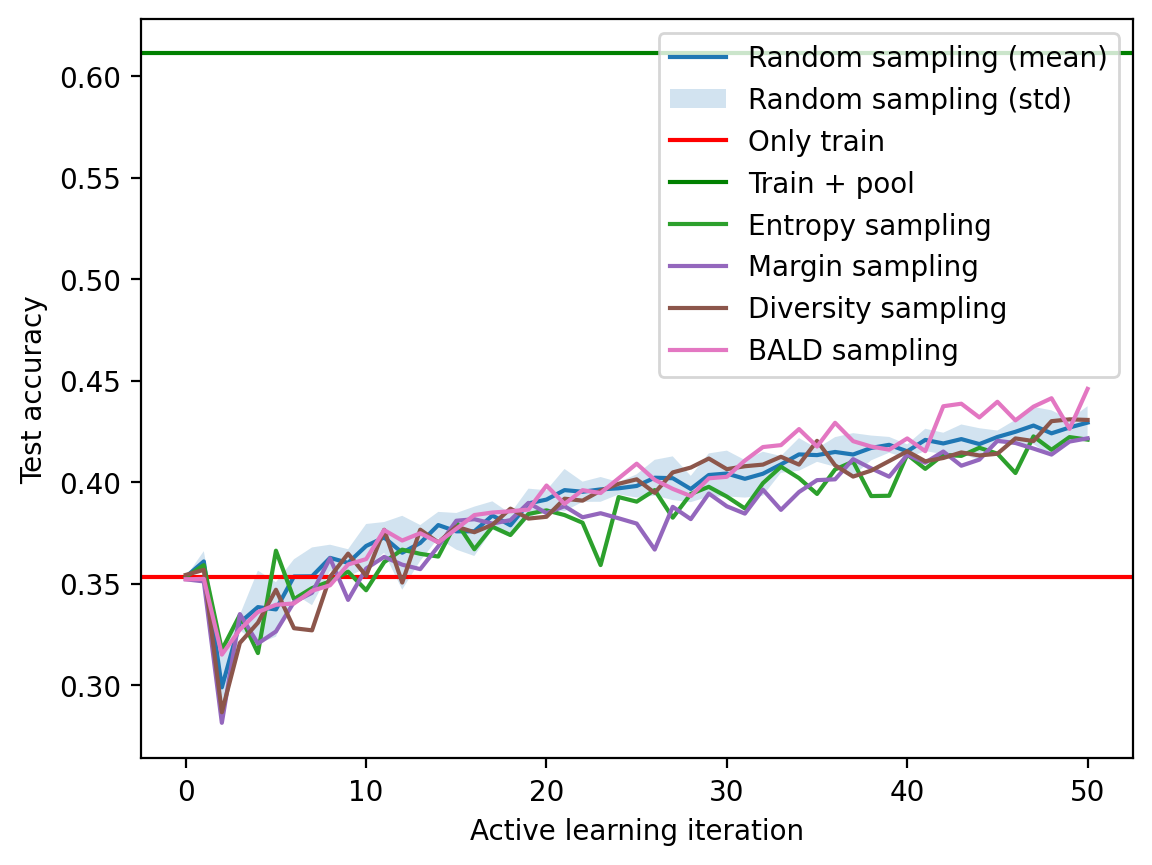

In [106]:
fig, ax = plt.subplots(1, 1)
ax.plot(mean_acc, label="Random sampling (mean)")
ax.fill_between(mean_acc.index, mean_acc-std_acc,
                 mean_acc+std_acc, alpha=0.2, label="Random sampling (std)")
ax.axhline(accuracy_only_train.cpu(), color='r', label='Only train')
ax.axhline(accuracy_train_plus_pool.cpu(), color='g', label='Train + pool')

pd.Series(test_acc_entropy).plot(ax=ax, label="Entropy sampling", color='C2')
pd.Series(test_acc_margin).plot(ax=ax, label="Margin sampling", color='C4')
pd.Series(test_acc_diversity).plot(ax=ax, label="Diversity sampling", color='C5')
pd.Series(test_acc_bald).plot(ax=ax, label="BALD sampling", color='C6')

ax.set_xlabel("Active learning iteration")
ax.set_ylabel("Test accuracy")
ax.legend()